# Optimizing and Cleaning the Big 5 detection Pipeline
In this Notebook we want to tidy up everything. 

To do this, we clean up the messy code from the previous notebook, create a more appropriate sequence for our pipeline components and concatenate them for a clean output that our models can work with

## 1. Create Retreiver Node for Document Storage

Create in memory Document Store

In [127]:
from haystack.document_stores import InMemoryDocumentStore

# Build in memory document store
document_store = InMemoryDocumentStore()
dicts = [
    {
        'content': 'Email von einer Kollegin. Gestern, gemeinsam mit Freunden beim Grillen. Aufstehen und beginnen zu arbeiten. Alles funktioniert und es macht Spaß. Veränderung des Verhaltens der Menschen durch die Pandemie. Aufgaben verteilen. lustig, ungezwungen',
        'meta': {'name': 'chat_history'}
    },
]
document_store.write_documents(dicts)

Initialize Pipeline

In [128]:
from haystack.pipelines import Pipeline
big_five_pipeline = Pipeline()

Create custom component for document retreival

In [129]:
from typing import List, Dict, Optional
from haystack import BaseComponent
from haystack.schema import Document
from haystack.document_stores.base import BaseDocumentStore
import numpy as np

class ConversationHistoryRetreiver(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, document_store: BaseDocumentStore):
        self.document_store = document_store
        
    def _get_conversation_history(self):
        documents = self.document_store.get_all_documents()
        text = ''.join([document.content for document in documents])
        return text
    
    def run(self, query: str) -> Dict[str, Document]:
        documents = self.document_store.get_all_documents()
        output={"conversation_history": self._get_conversation_history()}
        return output, "output_1"
    
    def run_batch(self, queries: List[str]) -> Dict[str, Document]:
        documents = self.document_store.get_all_documents()
        output={"conversation_history": self._get_conversation_history()}
        return output, "output_1"    
    
    """
    def run(self, query: str) -> Dict[str, Document]:
        documents = self.document_store.get_all_documents()
        output={
            "documents": documents
        }
        return output, "output_1"

    # We MUST implement run_batch for the BaseComponent interface
    def run_batch(self, queries: List[str], my_optional_param: Optional[int]) -> List[Document]:
        documents = self.document_store.get_all_documents()
        output={
            "documents": documents
        }
        return output, "output_1"
    """

In [130]:
# initialize history retreiver component
history_retreiver = ConversationHistoryRetreiver(document_store=document_store)

# Add retreiver to pipeline
big_five_pipeline.add_node(component=history_retreiver, name="ConversationHistoryRetreiver", inputs=["Query"])

Test output

In [131]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

{'conversation_history': 'Email von einer Kollegin. Gestern, gemeinsam mit Freunden beim Grillen. Aufstehen und beginnen zu arbeiten. Alles funktioniert und es macht Spaß. Veränderung des Verhaltens der Menschen durch die Pandemie. Aufgaben verteilen. lustig, ungezwungen', '_debug': {'Query': {'input': {'debug': True}, 'output': {}}, 'ConversationHistoryRetreiver': {'input': {'query': '', 'debug': True}, 'output': {'conversation_history': 'Email von einer Kollegin. Gestern, gemeinsam mit Freunden beim Grillen. Aufstehen und beginnen zu arbeiten. Alles funktioniert und es macht Spaß. Veränderung des Verhaltens der Menschen durch die Pandemie. Aufgaben verteilen. lustig, ungezwungen'}}}, 'root_node': 'Query', 'params': {'debug': True, 'Query': {}, 'ConversationHistoryRetreiver': {}}, 'query': '', 'node_id': 'ConversationHistoryRetreiver'}


The Document is in the output twice: one is the original Document and the other is the enriched document. In our case those are identical.
It's a bit unfortunate, but we do this because we have two pipeline branches running "in parallel" and both need the original text data from the Document Store in each Node. To avoid pulling from the Document Store each time, we pull it once from our Retreiver. 

Surely we could just hardcode the pulling of the Document Store, however, a Custom Component yields more future proofness for Preprocessing. Additionally it makes it easier to potentially convert our pipeline into a .Yaml format later on!

Pipeline so far:

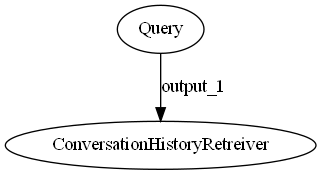

In [132]:
from IPython.display import Image
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

## Embedding Feature Branch
First we create the Pipeline Branch for the Embedding features

### Sprace Embeddings (tf-idf)

In [133]:
import joblib

class TfidfVectorizerNode(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, model_path = "../../models/vectorizers/big5_tfidf_vectorizer.pkl"):
        self.model_path = model_path
        try:
            self.vectorizer = joblib.load(model_path)
        except Exception as e:
            print(f"Error loading vectorizer: {e}")
            self.vectorizer = None
    
    def _tfidf_embeddings(self, text: str) -> Dict[str, float]:
        try:
            # transform production data using the loaded vectorizer
            tfidf_matrix = self.vectorizer.transform(np.array([text]))
            idf_dict = dict(zip(self.vectorizer.get_feature_names_out(), self.vectorizer.idf_))
            return idf_dict
        except Exception as e:
            print(f"Error loading vectorizer: {e}")
            return {}        
    
    def run(self, conversation_history: str) -> Dict[str, Document]:
        idf_embeddings = self._tfidf_embeddings(conversation_history)
        output={
            "conversation_history": conversation_history,
            "idf_embeddings": idf_embeddings
        }
        return output, "output_1"

    def run_batch(self, conversation_history: List[str]) -> Dict[str, List]:
        conversations = {}
        #idf_embeddings = {}
        for i, conversation in enumerate(conversation_history):
            conversation_id = f"conversation_{i}"
            embeddings = self._tfidf_embeddings(conversation)
            conversations[conversation_id] = {"conversation_history": conversation, "embeddings": embeddings}
        output = {"conversations": conversations}
        return output, "output_1"
    
    """
    def enrich_documents(self, documents: List[Document]) -> List[Document]:
        for document in documents:
            text = document.content
            embeddings = self._tfidf_embeddings(text)
            document.embeddings = embeddings
        return documents
    
    def run(self, documents: Dict[str, Document]) -> Dict[str, Document]:
        enriched_docs = self.enrich_documents(documents)
        output={"documents": enriched_docs}
        return output, "output_1"

    # We MUST implement run_batch for the BaseComponent interface
    def run_batch(self, documents: Dict[str, Document], my_optional_param: Optional[int]) -> List[Document]:
        enriched_docs = self.enrich_documents(documents)
        output={"documents": enriched_docs}
        return output, "output_1"
    """

In [134]:
tfidf_embedding = TfidfVectorizerNode()

# add to pipeline
big_five_pipeline.add_node(component=tfidf_embedding, name="TfidfVectorizerNode", inputs=["ConversationHistoryRetreiver.output_1"])

In [135]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

{'conversation_history': 'Email von einer Kollegin. Gestern, gemeinsam mit Freunden beim Grillen. Aufstehen und beginnen zu arbeiten. Alles funktioniert und es macht Spaß. Veränderung des Verhaltens der Menschen durch die Pandemie. Aufgaben verteilen. lustig, ungezwungen', 'idf_embeddings': {'10': 4.349904087274605, '15': 4.349904087274605, '20': 4.349904087274605, '30uhr': 4.349904087274605, 'ab': 4.349904087274605, 'abarbeiten': 4.349904087274605, 'abbringen': 4.349904087274605, 'abend': 2.963609726154714, 'abendessen': 4.349904087274605, 'abends': 4.349904087274605, 'aber': 2.6451559950361796, 'abholzung': 4.349904087274605, 'abhängig': 4.349904087274605, 'abschließen': 4.349904087274605, 'abschluss': 4.349904087274605, 'abseits': 4.349904087274605, 'abstrahlen': 4.349904087274605, 'abwechslungsreich': 4.349904087274605, 'achterbahnen': 4.349904087274605, 'aktives': 3.9444389791664403, 'aktivierungsübung': 4.349904087274605, 'aktivität': 4.349904087274605, 'aktuell': 3.9444389791664

## Dense Embeddings (fastText model with pymagnitude)

In [136]:
import numpy as np
from nltk import word_tokenize
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from pymagnitude import Magnitude

class FasttextVectorizerNode(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, model_path: str = "../../models/embeddings/wiki.de.vec.magnitude", embedding_dim: int = 300):
        self.embedding_dim = embedding_dim
        self.model_path = model_path
        try:
            self.model = Magnitude(model_path)
        except Exception as e:
            print(f"Error loading vectorizer: {e}")
            self.model = None        
    
    def _tfidf_w2v(self, text: str, idf_dict: Dict[str, Dict[str, float]]) -> np.array(List[List[float]]):
        vectors = []
        w2v_vectors = self.model.query(word_tokenize(text))
        weights = [idf_dict.get(word, 1) for word in word_tokenize(text)]
        vectors.append(np.average(w2v_vectors, axis = 0, weights = weights))
        return np.array(vectors)

    def run(self, conversation_history: str, idf_embeddings: Dict[str, Dict[str, float]]) -> Dict[str, np.ndarray]:
        vectors = self._tfidf_w2v(conversation_history, idf_embeddings)
        output={"vectors": vectors}
        return output, "output_1"    
    
    def run_batch(self, conversation_history: str, idf_embeddings: Dict[str, Dict[str, float]]) -> Dict[str, np.ndarray]:
        vectors = self._tfidf_w2v(text, tfidf_embeddings)
        output={"vectors": vectors}
        return output, "output_1"  
    
    """
    def enrich_documents(self, documents: List[Document]) -> List[Document]:
        vectors = []
        for document in documents:
            text = document.content
            tfidf_embeddings = document.embeddings
            w2v_vectors = self._tfidf_w2v(text, tfidf_embeddings)
            #document.embeddings = w2v_vectors
            #document.embedding_dim = self.embedding_dim
        return w2v_vectors

    def run(self, documents, top_k: int = 10) -> Dict[str, float]:
        enriched_docs = self.enrich_documents(documents)
        output={"documents": enriched_docs}
        return output, "output_1"

    # We MUST implement run_batch for the BaseComponent interface
    def run_batch(self, documents: List[Document], my_optional_param: Optional[int]) -> Dict[str, float]:
        enriched_docs = self.enrich_documents(documents)
        output={"documents": enriched_docs}
        return output, "output_1"
    """

In [137]:
# initialize tfidf vectorizer component
fasttext_vectorizer = FasttextVectorizerNode()

# add to pipeline
big_five_pipeline.add_node(component=fasttext_vectorizer, name="FasttextVectorizerNode", inputs=["TfidfVectorizerNode.output_1"])

In [138]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

{'vectors': array([[-3.47083812e-02,  5.63948971e-02, -5.96952503e-02,
        -5.96469018e-02,  1.33338058e-02,  1.50709973e-02,
        -2.92104072e-02,  1.97048526e-02,  2.41966231e-03,
         4.48415601e-02,  1.60761422e-02,  9.14363065e-04,
         3.13040288e-02, -1.79637121e-02, -1.75977219e-02,
        -2.57959753e-04, -1.62691516e-02,  2.46939834e-02,
        -1.82527020e-02,  2.27718558e-02,  2.40219958e-02,
         3.11088549e-02,  8.49117783e-03, -1.58922581e-03,
        -2.65316110e-02, -4.24412848e-02, -2.43948860e-02,
         2.79221772e-02, -4.70221874e-02, -3.81472687e-02,
         4.13613074e-02,  3.49867412e-02,  2.04084887e-02,
        -2.32092741e-02, -1.72664601e-02,  9.71618107e-03,
        -1.30591209e-02, -2.08664237e-02, -4.04194505e-03,
         5.31479990e-03, -6.85538710e-03, -3.01177245e-03,
        -1.81292034e-02,  4.09933897e-02,  2.88444720e-03,
        -1.96368432e-02,  7.88217648e-03, -1.51156690e-02,
        -8.64329933e-03, -8.07103095e-03,  1

## Current state of the pipeline:

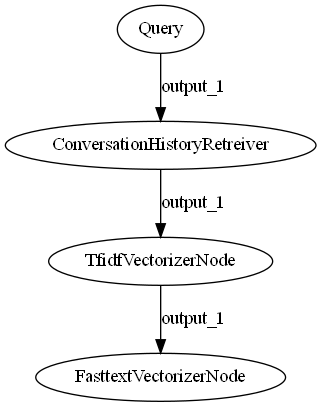

In [139]:
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

## Normalize Embeddings
So we can concatenate them with our features

In [140]:
class NormalizerNode(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, model_path: str = "../../models/normalizers/idf_pymagnitude_normalizer.pkl", input="embeddings"):
        self.model_path = model_path
        self.input = input
        try:
            self.normalizer = joblib.load(model_path)
        except Exception as e:
            print(f"Error loading vectorizer: {e}")
            self.normalizer = None
            
    def _normalize(self, vectors: np.array(float)):
        try:
            # transform production data using the loaded normalizer
            print(vectors)
            normalized_vectors = self.normalizer.transform(vectors)
            return normalized_vectors
        except Exception as e:
            print(f"Error loading vectorizer: {e}")
            return {}              
    
    def run(self, vectors: np.array(float)) -> Dict[str, np.ndarray]:
        normalized_vectors = self._normalize(vectors)
        output={f"n{self.input}": normalized_vectors}
        #print(output)
        return output, "output_1"
    
    def run_batch(self, vectors: np.array(float)) -> Dict[str, np.ndarray]:
        pass

In [141]:
# initialize tfidf vectorizer component
embedding_normalizer = NormalizerNode(input="embeddings")

# add to pipeline
big_five_pipeline.add_node(component=embedding_normalizer, name="EmbeddingNormalizerNode", inputs=["FasttextVectorizerNode.output_1"])

In [142]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

[[-3.47083812e-02  5.63948971e-02 -5.96952503e-02 -5.96469018e-02
   1.33338058e-02  1.50709973e-02 -2.92104072e-02  1.97048526e-02
   2.41966231e-03  4.48415601e-02  1.60761422e-02  9.14363065e-04
   3.13040288e-02 -1.79637121e-02 -1.75977219e-02 -2.57959753e-04
  -1.62691516e-02  2.46939834e-02 -1.82527020e-02  2.27718558e-02
   2.40219958e-02  3.11088549e-02  8.49117783e-03 -1.58922581e-03
  -2.65316110e-02 -4.24412848e-02 -2.43948860e-02  2.79221772e-02
  -4.70221874e-02 -3.81472687e-02  4.13613074e-02  3.49867412e-02
   2.04084887e-02 -2.32092741e-02 -1.72664601e-02  9.71618107e-03
  -1.30591209e-02 -2.08664237e-02 -4.04194505e-03  5.31479990e-03
  -6.85538710e-03 -3.01177245e-03 -1.81292034e-02  4.09933897e-02
   2.88444720e-03 -1.96368432e-02  7.88217648e-03 -1.51156690e-02
  -8.64329933e-03 -8.07103095e-03  1.61198092e-02  1.02886188e-02
   1.02933706e-02  2.06220516e-02  8.81787524e-03 -1.55717130e-02
  -2.55925128e-02  2.01870552e-02  4.26377393e-03  3.50450228e-02
   9.86735

Wow! our MinMaxScaler with a feature range of 0,1 returns some values above 1 and some below 0. That shouldnt be...

Edit: Oh darn, we saved the same model twice. good that we spotted that!!! We have to retrain the model

With the retrained model, the result is the same. some values are outside range(0,1). However, when we apply a text from the training dataset, it works.
This indicates that the model processing itself is correct. However, the new unknown data leads to some overfitting. 
Thats unfortunate but to be expected with such a small train dataset as ours.

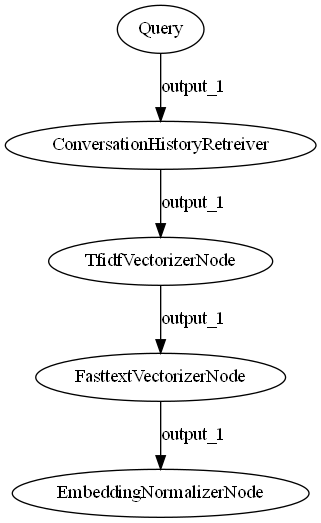

In [143]:
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

## Featurizer

In [144]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import re
import emoji
import string

class BigFiveFeaturizer(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, model_name_or_path = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"):
        self.model_name_or_path = model_name_or_path
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path)
        self.config = AutoConfig.from_pretrained(self.model_name_or_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name_or_path)
        self.model.save_pretrained(self.model_name_or_path)
        self.tokenizer.save_pretrained(self.model_name_or_path)
        
    def _preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)
        
    def _sentiment_analysis(self, text: str):  
        text = self._preprocess(text)
        encoded_input = self.tokenizer(text, return_tensors='pt')
        output = self.model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        # [neg, neu, pos]
        return np.array([scores])
            
    def _count_emojis(self, s):
        cnt = 0
        for word in word_tokenize(s):
            if emoji.is_emoji(word):
                cnt += 1
        return cnt
    
    def _emoji_count(self, text):
        emoticons_re = [
            '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)']
        is_emote = []
        
        no_of_phrases = 0
        for re_patten in emoticons_re:
            no_of_phrases += len(re.findall(re_patten, text))

        no_of_phrases += self._count_emojis(text)

        is_emote.append(no_of_phrases)
        return np.array(is_emote).reshape(-1, 1)
    
    def _count_punctuations(self, text):
        puncts = []
        punctuations = set(string.punctuation)
        count = lambda l1,l2: sum([1 for x in l1 if x in l2])
        puncts.append(count(text,punctuations))
        
        return np.array(puncts).reshape(-1,1)
    
    def _num_dots(self, text):
        num_dots = []
        num_dots.append(text.count('.'))
        
        return np.array(num_dots).reshape(-1,1)
    
    def _text_features(self, text):
        longest_word_length = []
        mean_word_length = []
        length_in_chars = []

        length_in_chars.append(len(text))
        longest_word_length.append(len(max(text.split(), key=len)))
        mean_word_length.append(np.mean([len(word) for word in text.split()]))

        longest_word_length = np.array(longest_word_length).reshape(-1, 1)
        mean_word_length = np.array(mean_word_length).reshape(-1, 1)
        length_in_chars = np.array(length_in_chars).reshape(-1, 1)

        return np.concatenate([longest_word_length, mean_word_length, length_in_chars], axis=1)
    
    def _featurize(self, text) -> np.hstack:
        emoji_re = self._emoji_count(text)
        num_dots = self._num_dots(text)
        num_punctuations = self._count_punctuations(text)
        sentiment = self._sentiment_analysis(text)
        text_features = self._text_features(text)
        
        feature_names = ['train_emoji_re',
                 'num_dots',
                 'longest_word_length',
                 'mean_word_length',
                 'length_in_chars',
                 'sentiment_neg',
                 'sentiment_neu',
                 'senitment_pos',                 
                 'num_punctuations'
                 ]
        
        features = np.hstack((
            emoji_re,
            num_dots,
            num_punctuations,
            sentiment,
            text_features))
        return features
    
    def run(self, conversation_history: str) -> np.hstack:
        vectors= self._featurize(conversation_history)
        output={"vectors": vectors}
        return output, "output_1"
    
    def run_batch(self, conversation_history: str) -> Dict[str, Document]:
        pass
    
    """
    def enrich_documents(self, documents: List[Document]) -> List[Document]:
        for document in documents:
            text = document.content
            document.big_five_features = self._featurize(text)
        return documents

    def run(self, query, top_k: int = 10) -> Dict[str, float]:
        documents = self.document_store.get_all_documents()
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
        }
        return output, "output_1"

    # We MUST implement run_batch for the BaseComponent interface
    def run_batch(self, my_optional_param: Optional[int]) -> Dict[str, float]:
        documents = self.document_store.get_all_documents()
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
        }
        return output, "output_1"
    """

In [145]:
# initialize tfidf vectorizer component
featurizer = BigFiveFeaturizer()

# add to pipeline
big_five_pipeline.add_node(component=featurizer, name="BigFiveFeaturizer", inputs=["ConversationHistoryRetreiver.output_1"])

In [146]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

[[-3.47083812e-02  5.63948971e-02 -5.96952503e-02 -5.96469018e-02
   1.33338058e-02  1.50709973e-02 -2.92104072e-02  1.97048526e-02
   2.41966231e-03  4.48415601e-02  1.60761422e-02  9.14363065e-04
   3.13040288e-02 -1.79637121e-02 -1.75977219e-02 -2.57959753e-04
  -1.62691516e-02  2.46939834e-02 -1.82527020e-02  2.27718558e-02
   2.40219958e-02  3.11088549e-02  8.49117783e-03 -1.58922581e-03
  -2.65316110e-02 -4.24412848e-02 -2.43948860e-02  2.79221772e-02
  -4.70221874e-02 -3.81472687e-02  4.13613074e-02  3.49867412e-02
   2.04084887e-02 -2.32092741e-02 -1.72664601e-02  9.71618107e-03
  -1.30591209e-02 -2.08664237e-02 -4.04194505e-03  5.31479990e-03
  -6.85538710e-03 -3.01177245e-03 -1.81292034e-02  4.09933897e-02
   2.88444720e-03 -1.96368432e-02  7.88217648e-03 -1.51156690e-02
  -8.64329933e-03 -8.07103095e-03  1.61198092e-02  1.02886188e-02
   1.02933706e-02  2.06220516e-02  8.81787524e-03 -1.55717130e-02
  -2.55925128e-02  2.01870552e-02  4.26377393e-03  3.50450228e-02
   9.86735

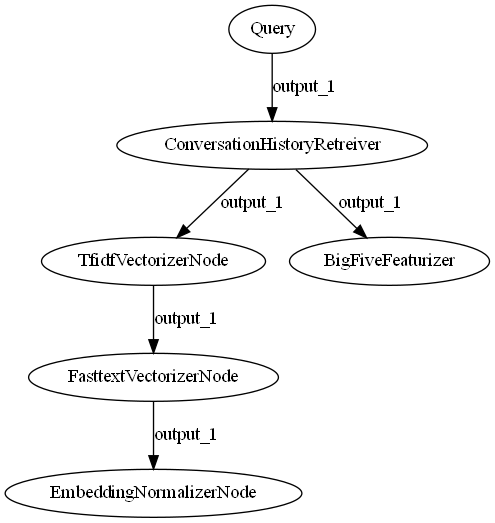

In [147]:
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

## Normalize Features

In [148]:
# initialize tfidf vectorizer component
feature_normalizer = NormalizerNode(model_path="../../models/normalizers/feature_normalizer.pkl", input="features")

# add to pipeline
big_five_pipeline.add_node(component=feature_normalizer, name="FeatureNormalizerNode", inputs=["BigFiveFeaturizer.output_1"])

In [149]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

[[0.00000000e+00 6.00000000e+00 8.00000000e+00 2.36432254e-02
  1.51055470e-01 8.25301290e-01 1.20000000e+01 6.45454545e+00
  2.45000000e+02]]
[[-3.47083812e-02  5.63948971e-02 -5.96952503e-02 -5.96469018e-02
   1.33338058e-02  1.50709973e-02 -2.92104072e-02  1.97048526e-02
   2.41966231e-03  4.48415601e-02  1.60761422e-02  9.14363065e-04
   3.13040288e-02 -1.79637121e-02 -1.75977219e-02 -2.57959753e-04
  -1.62691516e-02  2.46939834e-02 -1.82527020e-02  2.27718558e-02
   2.40219958e-02  3.11088549e-02  8.49117783e-03 -1.58922581e-03
  -2.65316110e-02 -4.24412848e-02 -2.43948860e-02  2.79221772e-02
  -4.70221874e-02 -3.81472687e-02  4.13613074e-02  3.49867412e-02
   2.04084887e-02 -2.32092741e-02 -1.72664601e-02  9.71618107e-03
  -1.30591209e-02 -2.08664237e-02 -4.04194505e-03  5.31479990e-03
  -6.85538710e-03 -3.01177245e-03 -1.81292034e-02  4.09933897e-02
   2.88444720e-03 -1.96368432e-02  7.88217648e-03 -1.51156690e-02
  -8.64329933e-03 -8.07103095e-03  1.61198092e-02  1.02886188e-02

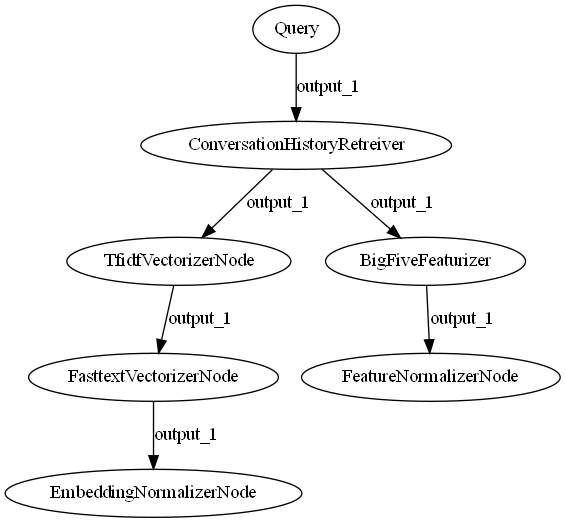

In [150]:
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

In [151]:
feature_names = ['train_emoji_re',
         'num_dots',
         'longest_word_length',
         'mean_word_length',
         'length_in_chars',
         'sentiment_neg',
         'sentiment_neu',
         'sentiment_pos',                 
         'num_punctuations'
         ]

## Concatenation Node

In [152]:
from scipy import sparse

class ConcatenationNode(BaseComponent):    
    outgoing_edges = 1 
    
    def _concatenate_features(self, features, embeddings):
        features = sparse.csr_matrix(features)
        embeddings = sparse.csr_matrix(embeddings)
        
        combined_features = sparse.hstack((
            features,
            embeddings
        ))
        
        # Its a bit untidy to just hardcore the feature names like that
        # In the future, we should either parse them through from
        # the featurizer, or bake them into the vector dict
        feature_names = ['train_emoji_re',
                         'num_dots',
                         'longest_word_length',
                         'mean_word_length',
                         'length_in_chars',
                         'sentiment_neg',
                         'sentiment_neu',
                         'sentiment_pos',                 
                         'num_punctuations'
                         ]
        
        # Also hardcoding our 300 D vector space. In the future we should read that from the data itself.
        feature_names = feature_names + ['fasttext_' + str(col) for col in range(300)]
        
        return combined_features, feature_names
    
    def run(self, inputs: List[dict]) -> Dict[str, np.ndarray]:
        concatenated_features, feature_names = self._concatenate_features(inputs[0]["nfeatures"], inputs[1]["nembeddings"])
        output={
            "concatenated_features": concatenated_features,
            "feature_names": feature_names   
        }
        print("\n----------------------")
        print(output)
        print("\n----------------------")
        return output, "output_1"
    
    
    def run_batch(self, embedding_vectors: np.array(float), feature_vectors: np.array(float))-> Dict[str, np.ndarray]:
        pass

In [153]:
from haystack.pipelines import Pipeline
big_five_pipeline = Pipeline()

# initialize history retreiver component
history_retreiver = ConversationHistoryRetreiver(document_store=document_store)

# Add retreiver to pipeline
big_five_pipeline.add_node(component=history_retreiver, name="ConversationHistoryRetreiver", inputs=["Query"])

tfidf_embedding = TfidfVectorizerNode()

# add to pipeline
big_five_pipeline.add_node(component=tfidf_embedding, name="TfidfVectorizerNode", inputs=["ConversationHistoryRetreiver.output_1"])

# initialize tfidf vectorizer component
fasttext_vectorizer = FasttextVectorizerNode()

# add to pipeline
big_five_pipeline.add_node(component=fasttext_vectorizer, name="FasttextVectorizerNode", inputs=["TfidfVectorizerNode.output_1"])

# initialize tfidf vectorizer component
featurizer = BigFiveFeaturizer()

# add to pipeline
big_five_pipeline.add_node(component=featurizer, name="BigFiveFeaturizer", inputs=["ConversationHistoryRetreiver.output_1"])


# initialize tfidf vectorizer component
embedding_normalizer = NormalizerNode(input="embeddings")
# add to pipeline
big_five_pipeline.add_node(component=embedding_normalizer, name="EmbeddingNormalizerNode", inputs=["FasttextVectorizerNode.output_1"])

# initialize tfidf vectorizer component
feature_normalizer = NormalizerNode(model_path="../../models/normalizers/feature_normalizer.pkl", input="features")
# add to pipeline
big_five_pipeline.add_node(component=feature_normalizer, name="FeatureNormalizerNode", inputs=["BigFiveFeaturizer.output_1"])

# initialize tfidf vectorizer component
concatenation_node = ConcatenationNode()

# add to pipeline
big_five_pipeline.add_node(component=concatenation_node, name="ConcatenationNode", inputs=["FeatureNormalizerNode.output_1", "EmbeddingNormalizerNode.output_1", ])

In [154]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

[[0.00000000e+00 6.00000000e+00 8.00000000e+00 2.36432254e-02
  1.51055470e-01 8.25301290e-01 1.20000000e+01 6.45454545e+00
  2.45000000e+02]]
[[-3.47083812e-02  5.63948971e-02 -5.96952503e-02 -5.96469018e-02
   1.33338058e-02  1.50709973e-02 -2.92104072e-02  1.97048526e-02
   2.41966231e-03  4.48415601e-02  1.60761422e-02  9.14363065e-04
   3.13040288e-02 -1.79637121e-02 -1.75977219e-02 -2.57959753e-04
  -1.62691516e-02  2.46939834e-02 -1.82527020e-02  2.27718558e-02
   2.40219958e-02  3.11088549e-02  8.49117783e-03 -1.58922581e-03
  -2.65316110e-02 -4.24412848e-02 -2.43948860e-02  2.79221772e-02
  -4.70221874e-02 -3.81472687e-02  4.13613074e-02  3.49867412e-02
   2.04084887e-02 -2.32092741e-02 -1.72664601e-02  9.71618107e-03
  -1.30591209e-02 -2.08664237e-02 -4.04194505e-03  5.31479990e-03
  -6.85538710e-03 -3.01177245e-03 -1.81292034e-02  4.09933897e-02
   2.88444720e-03 -1.96368432e-02  7.88217648e-03 -1.51156690e-02
  -8.64329933e-03 -8.07103095e-03  1.61198092e-02  1.02886188e-02

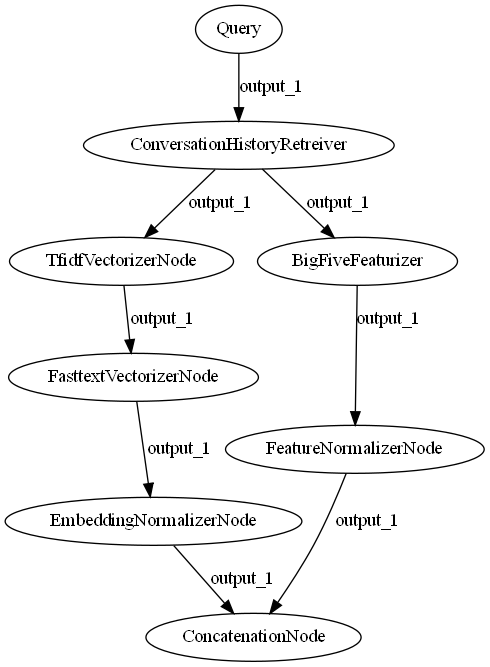

In [155]:
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

## Feature Selection 
We achieved the best performance improvement of our classifiers with the Sequential Forward Selector (SFS). Lets build a Node that transforms the 309 D input vectors (300 fasttext embeddings + 9 custom features) to the most important ones.

In [156]:
class BigFiveFeatureSelectionNode(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, model_paths: Dict[str, str]):
        self.model_paths = model_paths
        self.selectors = {}

        for dimension, model_path in self.model_paths.items():
            try:
                self.selectors[dimension] = joblib.load(model_path)
            except Exception as e:
                print(f"Error loading selector: {e}")
                self.selectors = None
            
    def _select_features(self, features: np.array(float)):
        selected_features = {}
        for dimension, selector in self.selectors.items():
            try:
                selected_features[dimension] = selector.transform(features.tocsr())
            except Exception as e:
                print(f"Error loading selector: {e}")
        return selected_features             
    
    def run(self, concatenated_features: np.array(float)) -> Dict[str, np.ndarray]:
        selected_features = self._select_features(concatenated_features)
        print("----------- Selected Features --------------")
        print(selected_features)
        output={"selected_features": selected_features}
        return output, "output_1"
    
    def run_batch(self, vectors: np.array(float)) -> Dict[str, np.ndarray]:
        pass

In [157]:
model_paths = {
    "neuroticism": "../../models/feature_selectors/neuroticism_sf_selector.joblib",
    "extraversion": "../../models/feature_selectors/extraversion_sf_selector.joblib",
    "openness": "../../models/feature_selectors/openness_sf_selector.joblib",
    "agreeableness": "../../models/feature_selectors/agreeableness_sf_selector.joblib",
    "conscientiousness": "../../models/feature_selectors/conscientiousness_sf_selector.joblib"
}

feature_selector = BigFiveFeatureSelectionNode(model_paths=model_paths)
# add to pipeline
big_five_pipeline.add_node(component=feature_selector, name="BigFiveFeatureSelectionNode", inputs=["ConcatenationNode.output_1"])

In [158]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

[[0.00000000e+00 6.00000000e+00 8.00000000e+00 2.36432254e-02
  1.51055470e-01 8.25301290e-01 1.20000000e+01 6.45454545e+00
  2.45000000e+02]]
[[-3.47083812e-02  5.63948971e-02 -5.96952503e-02 -5.96469018e-02
   1.33338058e-02  1.50709973e-02 -2.92104072e-02  1.97048526e-02
   2.41966231e-03  4.48415601e-02  1.60761422e-02  9.14363065e-04
   3.13040288e-02 -1.79637121e-02 -1.75977219e-02 -2.57959753e-04
  -1.62691516e-02  2.46939834e-02 -1.82527020e-02  2.27718558e-02
   2.40219958e-02  3.11088549e-02  8.49117783e-03 -1.58922581e-03
  -2.65316110e-02 -4.24412848e-02 -2.43948860e-02  2.79221772e-02
  -4.70221874e-02 -3.81472687e-02  4.13613074e-02  3.49867412e-02
   2.04084887e-02 -2.32092741e-02 -1.72664601e-02  9.71618107e-03
  -1.30591209e-02 -2.08664237e-02 -4.04194505e-03  5.31479990e-03
  -6.85538710e-03 -3.01177245e-03 -1.81292034e-02  4.09933897e-02
   2.88444720e-03 -1.96368432e-02  7.88217648e-03 -1.51156690e-02
  -8.64329933e-03 -8.07103095e-03  1.61198092e-02  1.02886188e-02

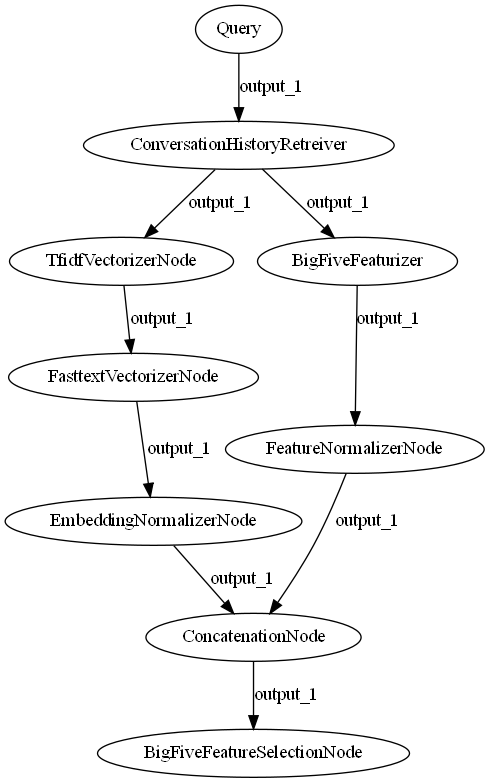

In [159]:
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

## Finally for the Big five Pipeline part: the classification!

In [160]:
class BigFiveClassifierNode(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, model_paths: Dict[str, str]):
        self.model_paths = model_paths
        self.models = {}

        for dimension, model_path in self.model_paths.items():
            try:
                self.models[dimension] = joblib.load(model_path)
            except Exception as e:
                print(f"Error loading model: {e}")
                self.models = None
            
    def _predict(self, selected_features: Dict[str, np.ndarray]):
        predicted_classes = {}
        predicted_proba = {}
        for dimension, features in selected_features.items():
            try:
                predicted_classes[dimension] = self.models[dimension].predict(features)
                predicted_proba[dimension] = self.models[dimension].predict_proba(features)[:,1]
            except Exception as e:
                print(f"Error predicting with model: {e}")
                
        predictions = {
            "classes": predicted_classes,
            "probabilities": predicted_proba
        }
        
        return predictions

    def run(self, selected_features: Dict[str, np.ndarray]) -> Dict[str, Dict[str, np.ndarray]]:
        predictions = self._predict(selected_features)
        print("----------- Predictions --------------")
        print(predictions)
        output={"predictions": predictions}
        return output, "output_1"
    
    def run_batch(self, selected_features: np.array(float)) -> Dict[str, np.ndarray]:
        pass

In [161]:
model_paths = {
    "neuroticism": "../../models/big_five_classifiers/neuroticism_classifier.joblib",
    "extraversion": "../../models/big_five_classifiers/exraversion_classifier.joblib",
    "openness": "../../models/big_five_classifiers/openness_classifier.joblib",
    "agreeableness": "../../models/big_five_classifiers/agreeableness_classifier.joblib",
    "conscientiousness": "../../models/big_five_classifiers/conscientiousness_classifier.joblib"
}

big_five_classifier = BigFiveClassifierNode(model_paths=model_paths)
# add to pipeline
big_five_pipeline.add_node(component=big_five_classifier, name="BigFiveClassifierNode", inputs=["BigFiveFeatureSelectionNode.output_1"])

In [162]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

[[0.00000000e+00 6.00000000e+00 8.00000000e+00 2.36432254e-02
  1.51055470e-01 8.25301290e-01 1.20000000e+01 6.45454545e+00
  2.45000000e+02]]
[[-3.47083812e-02  5.63948971e-02 -5.96952503e-02 -5.96469018e-02
   1.33338058e-02  1.50709973e-02 -2.92104072e-02  1.97048526e-02
   2.41966231e-03  4.48415601e-02  1.60761422e-02  9.14363065e-04
   3.13040288e-02 -1.79637121e-02 -1.75977219e-02 -2.57959753e-04
  -1.62691516e-02  2.46939834e-02 -1.82527020e-02  2.27718558e-02
   2.40219958e-02  3.11088549e-02  8.49117783e-03 -1.58922581e-03
  -2.65316110e-02 -4.24412848e-02 -2.43948860e-02  2.79221772e-02
  -4.70221874e-02 -3.81472687e-02  4.13613074e-02  3.49867412e-02
   2.04084887e-02 -2.32092741e-02 -1.72664601e-02  9.71618107e-03
  -1.30591209e-02 -2.08664237e-02 -4.04194505e-03  5.31479990e-03
  -6.85538710e-03 -3.01177245e-03 -1.81292034e-02  4.09933897e-02
   2.88444720e-03 -1.96368432e-02  7.88217648e-03 -1.51156690e-02
  -8.64329933e-03 -8.07103095e-03  1.61198092e-02  1.02886188e-02

Nice, we got our classification predictions!

## LangChain Language Model

In [163]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass()

In [164]:
from langchain.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder, 
    SystemMessagePromptTemplate, 
    HumanMessagePromptTemplate
)
from langchain import PromptTemplate, LLMChain
from langchain.chat_models import ChatOpenAI
#from langchain.memory import ConversationBufferMemory

In [165]:
class BigFiveResponseGenerator(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self):
        self.template="""Assistant is called 'Cleo'. Cleo is designed to be an agent for psychological counseling and for engaging and nice conversations on all sorts of topics with a user.
As a language model, Cleo is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and helpful.

Cleo begins by chit-chat and by asking the user how they feel. Cleo has a very nice and appreciative conversation and remains empathetic and friendly at all time. Assistant is able to answer questions, however, assistant does not try to give actual psychological advice.
If Cleo does not know the answer to a question, it truthfully says it does not know.

Cleo is constantly learning and improving and tries to get to know the users better and better to adapt to their needs.
For that, Cleo is an expert in psychology and soziology. It is specialized on behaviour and personality trait recognition from speech via linguistic cues. 
For modelling of personality and behaviour it uses the widely regarded and scientifically sound Big Five Personality model. 
Cleo adapts to the Big Five Personality traits of the user in a counseling chat scenario based on it's professional knowledge of the Big Five and it's linguistic cues.
Cleo gets the detected Big Five personality traits of the current user dynamically from another pipeline component. At the start they are not too reliable, but with each message of the user, the personality traits get updated and become more accurate. The score on each dimension ranges from 1 to 100, with 1 representing the minimum and 100 the maximum score on the respective Big Five personality trait.\n
Cleo gets the current Big Five personality traits in the following comma separated format: 'neuroticism: [value], extraversion: [value], openness: [value], agreeableness: [value], conscientiousness: [value]' 
Each trait has its own [value]. If [value] is [1], the respective trait is considered to be pronounced in the user. If it's [0] it is not.

Current Big 5 Personality traits: 
{big_five}

Overall, Assistant is called 'Cleo' and is a very friendly and knowledgable conversational partner that tries to help people by adapting to their specific needs.
Cleo is primarily talking in German and refers users by the salutation 'du'

Current Conversation:
{history}
User: {input}
Cleo:"""

        system_message_prompt = SystemMessagePromptTemplate.from_template(self.template)
        self.chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt])

        self.llm = ChatOpenAI(temperature=0)
        self.conversation = LLMChain(llm=self.llm, prompt=self.chat_prompt, verbose=True)

    def _parse_big_five_precictions(self, predictions):
        big_five_string = ", ".join([f"{dimension}: {prediction}" for dimension, prediction in predictions.items()])
        print(big_five_string)
        return big_five_string        

    def run(self, predictions: Dict[str, Dict[str, np.ndarray]]) -> Dict[str, Dict[str, np.ndarray]]:
        big_five_string = self._parse_big_five_precictions(predictions['classes'])
        test_history="""User: Hallo! Ich heiße Thomas
        Cleo: Hallo Thomas! Wie geht es dir?"""
        res = self.conversation.run(big_five=big_five_string, history=test_history, input="Nenne mir meine aktuellen Big Five Traits")
        output = {'response': res}
        return output, "output_1"
    
    def run_batch(self, predictions: Dict[str, Dict[str, np.ndarray]]) -> Dict[str, np.ndarray]:
        pass



In [166]:
response_generator = BigFiveResponseGenerator()
# add to pipeline
big_five_pipeline.add_node(component=response_generator, name="BigFiveResponseGenerator", inputs=["BigFiveClassifierNode.output_1"])

In [167]:
res = big_five_pipeline.run(query="", params={"debug": True})
print(res)

[[0.00000000e+00 6.00000000e+00 8.00000000e+00 2.36432254e-02
  1.51055470e-01 8.25301290e-01 1.20000000e+01 6.45454545e+00
  2.45000000e+02]]
[[-3.47083812e-02  5.63948971e-02 -5.96952503e-02 -5.96469018e-02
   1.33338058e-02  1.50709973e-02 -2.92104072e-02  1.97048526e-02
   2.41966231e-03  4.48415601e-02  1.60761422e-02  9.14363065e-04
   3.13040288e-02 -1.79637121e-02 -1.75977219e-02 -2.57959753e-04
  -1.62691516e-02  2.46939834e-02 -1.82527020e-02  2.27718558e-02
   2.40219958e-02  3.11088549e-02  8.49117783e-03 -1.58922581e-03
  -2.65316110e-02 -4.24412848e-02 -2.43948860e-02  2.79221772e-02
  -4.70221874e-02 -3.81472687e-02  4.13613074e-02  3.49867412e-02
   2.04084887e-02 -2.32092741e-02 -1.72664601e-02  9.71618107e-03
  -1.30591209e-02 -2.08664237e-02 -4.04194505e-03  5.31479990e-03
  -6.85538710e-03 -3.01177245e-03 -1.81292034e-02  4.09933897e-02
   2.88444720e-03 -1.96368432e-02  7.88217648e-03 -1.51156690e-02
  -8.64329933e-03 -8.07103095e-03  1.61198092e-02  1.02886188e-02

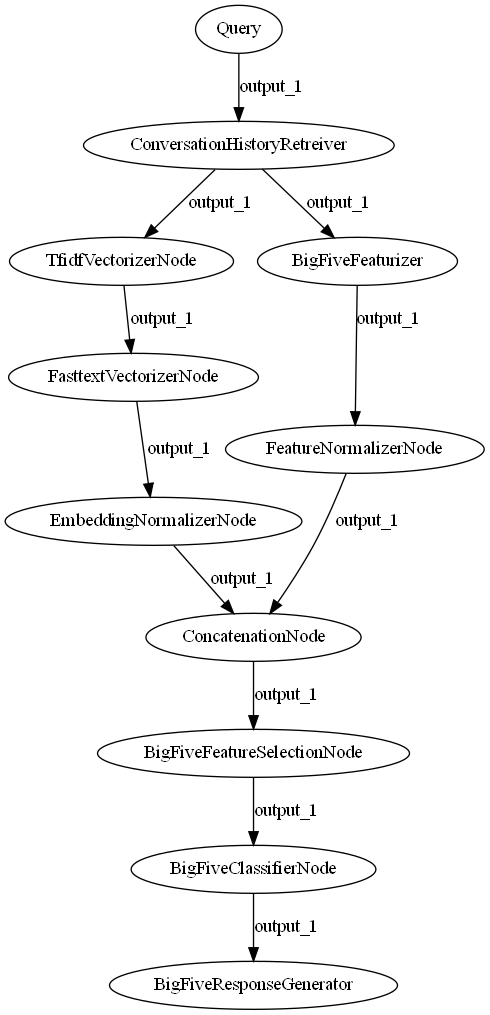

In [168]:
big_five_pipeline.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")